# Kalman Filter

In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.scipy as jsp

from filterjax import KalmanFilter, KalmanParams

%load_ext autoreload
%autoreload 2

In [2]:
class DogSensor:

    def __init__(self, key, x0=0, velocity=1, noise=0.0):
        self.key = key
        self.x = jnp.array(x0)
        self.velocity = jnp.array(velocity)
        self.noise = jnp.sqrt(noise)

    def sense(self, shape: tuple = (1,)):
        x = []
        for _ in range(shape[0]):
            self.x += self.velocity
            x.append(self.x)
    
        return jnp.array(x) + jax.random.normal(self.key, shape) * self.noise

In [3]:
movement = 1
movement_error = 2
sensor_error = 10
pos = (0, 500)

key = jax.random.PRNGKey(0)
dog = DogSensor(key, x0=pos[0], velocity=movement, noise=sensor_error)
measurements = dog.sense((50,))

In [4]:
def Q_DWPA(dim, dt=1., sigma=1.):
    assert dim == 2 or dim == 3
    if dim == 2:
        Q = jnp.array([[.25*dt**4, .5*dt**3],
                    [ .5*dt**3,    dt**2]], dtype=float)
    else:
        Q = jnp.array([[.25*dt**4, .5*dt**3, .5*dt**2],
                    [ .5*dt**3,    dt**2,       dt],
                    [ .5*dt**2,       dt,        1]], dtype=float)
    return Q * sigma

In [20]:
params = KalmanParams(
    F = jnp.array([[1, 1], [0, 1]]),
    H = jnp.array([[1, 0]]),
    Q = Q_DWPA(2, sigma=0.),
    R = jnp.eye(1) * 5,
    P = jnp.eye(2) * 500.,
    m = jnp.array([0., 0.])
)

In [31]:
kf = KalmanFilter(dim_m=2, dim_y=1)
params = kf.initialize(params)
posterior = kf.filter(params, measurements)

pos = posterior.mean[:, 0]
velocity = posterior.mean[:, 1]

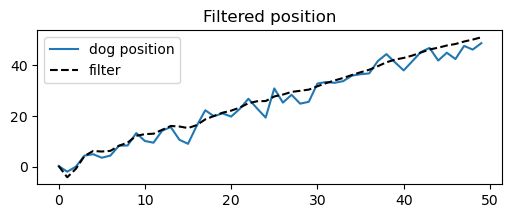

In [37]:
plt.figure(figsize=(6, 2))
plt.plot(jnp.arange(0, len(measurements), 1), measurements, label="dog position")
plt.plot(
    jnp.arange(0, len(measurements), 1), pos, label="filter", linestyle="--",
    color="black"
)
plt.title("Filtered position")
plt.legend(loc="best")
plt.show()

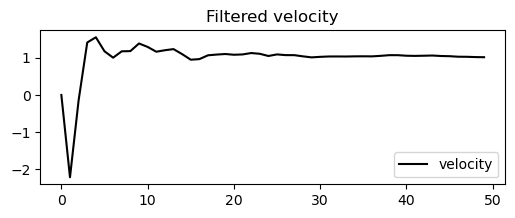

In [38]:
plt.figure(figsize=(6, 2))
plt.plot(
    jnp.arange(0, len(measurements), 1), velocity, label="velocity", linestyle="-",
    color="black"
)
plt.title("Filtered velocity")
plt.legend(loc="best")
plt.show()